In [3]:
# unzip file
from zipfile import ZipFile

fileName = 'archive'

with ZipFile("demo_data/"+fileName+".zip", 'r') as zObject:
    zObject.extractall(
      path="demo_data/")

In [45]:
#!conda install opencv -y

In [8]:
import os
import cv2
import numpy as np

from matplotlib import pyplot as plt
from patchify import patchify
from PIL import Image
#import segmentation_models as sm
from tensorflow.keras.metrics import MeanIoU

from sklearn.preprocessing import MinMaxScaler, StandardScaler

os.environ["SM_FRAMEWORK"] = "tf.keras"

from tensorflow import keras
import segmentation_models as sm

"""
Use patchify....
Tile 1: 797 x 644 --> 768 x 512 --> 6
Tile 2: 509 x 544 --> 512 x 256 --> 2
Tile 3: 682 x 658 --> 512 x 512  --> 4
Tile 4: 1099 x 846 --> 1024 x 768 --> 12
Tile 5: 1126 x 1058 --> 1024 x 1024 --> 16
Tile 6: 859 x 838 --> 768 x 768 --> 9
Tile 7: 1817 x 2061 --> 1792 x 2048 --> 56
Tile 8: 2149 x 1479 --> 1280 x 2048 --> 40
Total 9 images in each folder * (145 patches) = 1305
Total 1305 patches of size 256x256
"""


scaler = MinMaxScaler()

#root_directory = 'demo_data/Semantic segmentation dataset/'
#root_directory = 'satData/S2B_MSIL2A_20230612T073619_N0509_R092_T37NCC_20230612T101141\.SAFE/GRANULE/L2A_T37NCC_A032722_20230612T075442/IMG_DATA/R10m/'
#root_directory = 'bands'

patch_size = 128

In [9]:
#root_directory = 'satData/S2B_MSIL2A_20230612T073619_N0509_R092_T37NCC_20230612T101141.SAFE/GRANULE/L2A_T37NCC_A032722_20230612T075442/IMG_DATA/'
root_directory = '/home/jovyan/u_net'
root_directory

'/home/jovyan/u_net'

In [10]:
#Read images from repsective 'images' subdirectory
#As all images are of ddifferent size we have 2 options, either resize or crop
#But, some images are too large and some small. Resizing will change the size of real objects.
#Therefore, we will crop them to a nearest size divisible by 256 and then 
#divide all images into patches of 256x256x3. 
image_dataset = []  
for path, subdirs, files in os.walk(root_directory):
    print(path)  
    dirname = path.split(os.path.sep)[-1]
    #if dirname == 'R10m':   #Find all 'images' directories
    if dirname == 'images':   #Find all 'images' directories
        images = os.listdir(path)  #List of all image names in this subdirectory
        for i, image_name in enumerate(images):  
            if image_name.endswith(".tiff"):   #Only read jpg images...
               
                image = cv2.imread(path+"/"+image_name, 1)  #Read each image as BGR
                SIZE_X = (image.shape[1]//patch_size)*patch_size #Nearest size divisible by our patch size
                SIZE_Y = (image.shape[0]//patch_size)*patch_size #Nearest size divisible by our patch size
                image = Image.fromarray(image)
                image = image.crop((0 ,0, SIZE_X, SIZE_Y))  #Crop from top left corner
                #image = image.resize((SIZE_X, SIZE_Y))  #Try not to resize for semantic segmentation
                image = np.array(image)             
       
                #Extract patches from each image
                print("Now patchifying image:", path+"/"+image_name)
                patches_img = patchify(image, (patch_size, patch_size, 3), step=patch_size)  #Step=256 for 256 patches means no overlap
        
                for i in range(patches_img.shape[0]):
                    for j in range(patches_img.shape[1]):
                        
                        single_patch_img = patches_img[i,j,:,:]
                        
                        #Use minmaxscaler instead of just dividing by 255. 
                        single_patch_img = scaler.fit_transform(single_patch_img.reshape(-1, single_patch_img.shape[-1])).reshape(single_patch_img.shape)
                        
                        #single_patch_img = (single_patch_img.astype('float32')) / 255. 
                        single_patch_img = single_patch_img[0] #Drop the extra unecessary dimension that patchify adds.                               
                        image_dataset.append(single_patch_img)
                

/home/jovyan/u_net
/home/jovyan/u_net/images
Now patchifying image: /home/jovyan/u_net/images/eichenberg_feb24.tiff
/home/jovyan/u_net/images/.ipynb_checkpoints
/home/jovyan/u_net/.ipynb_checkpoints
/home/jovyan/u_net/masks
/home/jovyan/u_net/masks/.ipynb_checkpoints


In [24]:
#Now do the same as above for masks
#For this specific dataset we could have added masks to the above code as masks have extension png
mask_dataset = []  
for path, subdirs, files in os.walk('/home/jovyan/u_net'):
    #print(path)  
    dirname = path.split(os.path.sep)[-1]
    if dirname == 'masks':   #Find all 'images' directories
        masks = os.listdir(path)  #List of all image names in this subdirectory
        for i, mask_name in enumerate(masks):  
            if mask_name.endswith("classification_mask_rgb.png"):   #Only read png images... (masks in this dataset)
               
                mask = cv2.imread(path+"/"+mask_name, 1)  #Read each image as Grey (or color but remember to map each color to an integer)
                mask = cv2.cvtColor(mask,cv2.COLOR_BGR2RGB)
                SIZE_X = (mask.shape[1]//patch_size)*patch_size #Nearest size divisible by our patch size
                SIZE_Y = (mask.shape[0]//patch_size)*patch_size #Nearest size divisible by our patch size
                mask = Image.fromarray(mask)
                mask = mask.crop((0 ,0, SIZE_X, SIZE_Y))  #Crop from top left corner
                #mask = mask.resize((SIZE_X, SIZE_Y))  #Try not to resize for semantic segmentation
                mask = np.array(mask)             
       
                #Extract patches from each image
                print("Now patchifying mask:", path+"/"+mask_name)
                patches_mask = patchify(mask, (patch_size, patch_size, 3), step=patch_size)  #Step=256 for 256 patches means no overlap
        
                for i in range(patches_mask.shape[0]):
                    for j in range(patches_mask.shape[1]):
                        
                        single_patch_mask = patches_mask[i,j,:,:]
                        #single_patch_img = (single_patch_img.astype('float32')) / 255. #No need to scale masks, but you can do it if you want
                        single_patch_mask = single_patch_mask[0] #Drop the extra unecessary dimension that patchify adds.                               
                        mask_dataset.append(single_patch_mask) 
 

Now patchifying mask: /home/jovyan/u_net/masks/sololo_jan23_classification_mask_rgb.png


In [25]:
image_dataset = np.array(image_dataset)
#len(image_dataset)
image_dataset.shape
#image_dataset

(40, 256, 256, 3)

In [26]:
mask_dataset =  np.array(mask_dataset)
#len(mask_dataset)
mask_dataset.shape

(40, 256, 256, 3)

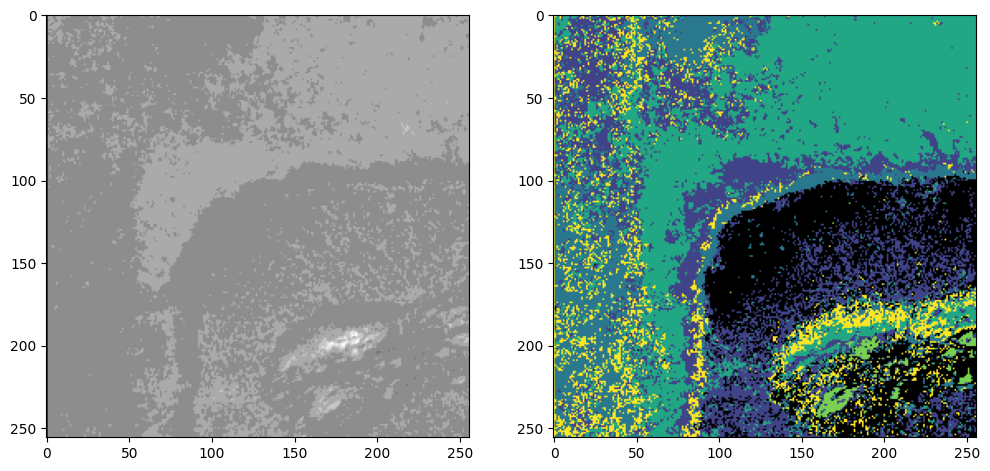

In [35]:
#Sanity check, view few mages
import random
import numpy as np
image_number = random.randint(0, len(mask_dataset))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(np.reshape(image_dataset[image_number], (patch_size, patch_size, 3)))
plt.subplot(122)
plt.imshow(np.reshape(mask_dataset[image_number], (patch_size, patch_size, 3)))
plt.show()

In [36]:
"""
RGB to HEX: (Hexadecimel --> base 16)
This number divided by sixteen (integer division; ignoring any remainder) gives 
the first hexadecimal digit (between 0 and F, where the letters A to F represent 
the numbers 10 to 15). The remainder gives the second hexadecimal digit. 
0-9 --> 0-9
10-15 --> A-F
Example: RGB --> R=201, G=, B=
R = 201/16 = 12 with remainder of 9. So hex code for R is C9 (remember C=12)
Calculating RGB from HEX: #3C1098
3C = 3*16 + 12 = 60
10 = 1*16 + 0 = 16
98 = 9*16 + 8 = 152
"""
## Convert HEX to RGB array
## Try the following to understand how python handles hex values...

#a=int('3C', 16)  #3C with base 16. Should return 60. 
#print(a)

##Do the same for all RGB channels in each hex code to convert to RGB
#Building = '#3C1098'.lstrip('#')
#Building = np.array(tuple(int(Building[i:i+2], 16) for i in (0, 2, 4))) # 60, 16, 152

#Land = '#8429F6'.lstrip('#')
#Land = np.array(tuple(int(Land[i:i+2], 16) for i in (0, 2, 4))) #132, 41, 246

#Road = '#6EC1E4'.lstrip('#') 
#Road = np.array(tuple(int(Road[i:i+2], 16) for i in (0, 2, 4))) #110, 193, 228

#Vegetation =  'FEDD3A'.lstrip('#') 
#Vegetation = np.array(tuple(int(Vegetation[i:i+2], 16) for i in (0, 2, 4))) #254, 221, 58

#Water = 'E2A929'.lstrip('#') 
#Water = np.array(tuple(int(Water[i:i+2], 16) for i in (0, 2, 4))) #226, 169, 41

#Unlabeled = '#9B9B9B'.lstrip('#') 
#Unlabeled = np.array(tuple(int(Unlabeled[i:i+2], 16) for i in (0, 2, 4))) #155, 155, 155

#####################################################################
#label1=np.array((254, 221, 58))
#label2=np.array((110, 193, 228))
#label3=np.array((60, 16, 152))
#label4=np.array((132, 41, 246))

#Building=np.array((60, 16, 152))
#Land=np.array((126, 16, 152))
#Road=np.array((244, 51, 171))
#Vegetation=np.array((254, 221, 58))
#Water=np.array((226, 169, 41))
#Unlabeled=np.array((155, 155, 155))
###########################################################################
label1=np.array((121,209,81))
label2=np.array((34,167,132))
label3=np.array((41,120,142))
label4=np.array((64,67,135))
label5=np.array((253,231,36))

Building=np.array((60, 16, 152))
Land=np.array((126, 16, 152))
Road=np.array((244, 51, 171))
Vegetation=np.array((254, 221, 58))
Water=np.array((226, 169, 41))
Unlabeled=np.array((0, 0, 0))

In [37]:
label = single_patch_mask

# Now replace RGB to integer values to be used as labels.
#Find pixels with combination of RGB for the above defined arrays...
#if matches then replace all values in that pixel with a specific integer
def rgb_to_2D_label(label):
    """
    Suply our labale masks as input in RGB format. 
    Replace pixels with specific RGB values ...
    """
    label_seg = np.zeros(label.shape,dtype=np.uint8)
    label_seg [np.all(label==Building,axis=-1)] = 0
    label_seg [np.all(label==Land,axis=-1)] = 1
    label_seg [np.all(label==Road,axis=-1)] = 2
    label_seg [np.all(label==Vegetation,axis=-1)] = 3
    label_seg [np.all(label==Water,axis=-1)] = 4
    label_seg [np.all(label==Unlabeled,axis=-1)] = 5
    label_seg [np.all(label==label1,axis=-1)] = 6
    label_seg [np.all(label==label2,axis=-1)] = 7
    label_seg [np.all(label==label3,axis=-1)] = 8
    label_seg [np.all(label==label4,axis=-1)] = 9
    
    label_seg = label_seg[:,:,0]  #Just take the first channel, no need for all 3 channels
    
    return label_seg

labels = []
for i in range(mask_dataset.shape[0]):
    label = rgb_to_2D_label(mask_dataset[i])
    labels.append(label)    

labels = np.array(labels)   
labels = np.expand_dims(labels, axis=3)
 

print("Unique labels in label dataset are: ", np.unique(labels))

Unique labels in label dataset are:  [0 5 6 7 8 9]


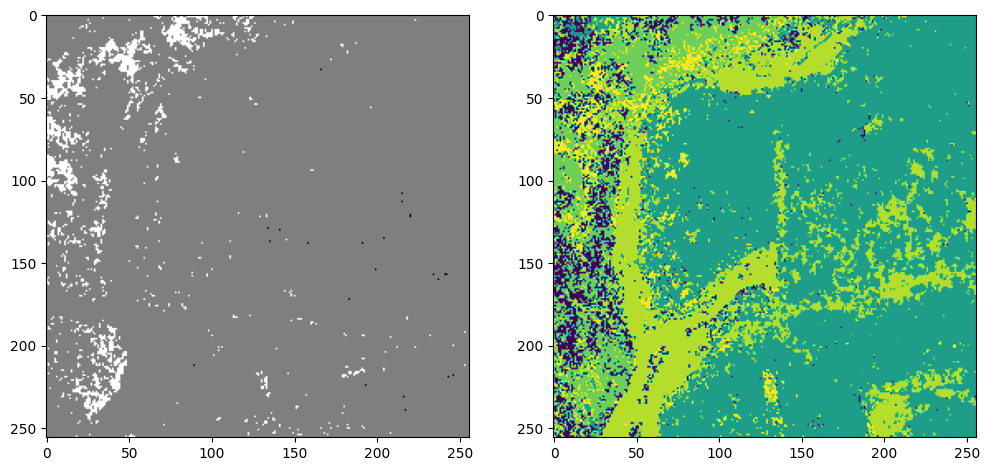

In [43]:
#Another Sanity check, view few images
import random
import numpy as np
image_number = random.randint(0, len(mask_dataset))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(image_dataset[image_number])
plt.subplot(122)
plt.imshow(labels[image_number][:,:,0])
plt.show()

In [49]:

#n_classes = len(np.unique(labels))
n_classes=10

from keras.utils import to_categorical
labels_cat = to_categorical(labels, num_classes=n_classes)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(image_dataset, labels_cat, test_size = 0.20, random_state = 42)


In [50]:

weights = [0.1666, 0.1666, 0.1666, 0.1666, 0.1666, 0.1666, 0.1666, 0.1666, 0.1666, 0.1666]
dice_loss = sm.losses.DiceLoss(class_weights=weights) 
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)  #

In [51]:
IMG_HEIGHT = X_train.shape[1]
IMG_WIDTH  = X_train.shape[2]
IMG_CHANNELS = X_train.shape[3]

In [52]:
#y_test

In [53]:
from simple_multi_unet_model import multi_unet_model, jacard_coef  

metrics=['accuracy', jacard_coef]

def get_model():
    return multi_unet_model(n_classes=n_classes, IMG_HEIGHT=IMG_HEIGHT, IMG_WIDTH=IMG_WIDTH, IMG_CHANNELS=IMG_CHANNELS)

model = get_model()
#model.compile(optimizer='adam', loss=total_loss, metrics=metrics)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=metrics)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 16)         448       ['input_1[0][0]']             
                                                                                                  
 dropout (Dropout)           (None, 256, 256, 16)         0         ['conv2d[0][0]']              
                                                                                                  
 conv2d_1 (Conv2D)           (None, 256, 256, 16)         2320      ['dropout[0][0]']             
                                                                                              

In [54]:
history1 = model.fit(X_train, y_train, 
                    batch_size = 16, 
                    verbose=1, 
                    epochs=20, 
                    validation_data=(X_test, y_test), 
                    shuffle=False)

Epoch 1/20
2/2 [==============================] - 11s 4s/step - loss: 2.3816 - accuracy: 0.0978 - jacard_coef: 0.0519 - val_loss: 2.2121 - val_accuracy: 0.1165 - val_jacard_coef: 0.0598
Epoch 2/20
2/2 [==============================] - 6s 3s/step - loss: 2.2469 - accuracy: 0.1389 - jacard_coef: 0.0637 - val_loss: 2.1575 - val_accuracy: 0.1200 - val_jacard_coef: 0.0630
Epoch 3/20
2/2 [==============================] - 6s 3s/step - loss: 2.1461 - accuracy: 0.1659 - jacard_coef: 0.0654 - val_loss: 2.0660 - val_accuracy: 0.2107 - val_jacard_coef: 0.0708
Epoch 4/20
2/2 [==============================] - 6s 3s/step - loss: 2.0528 - accuracy: 0.2339 - jacard_coef: 0.0774 - val_loss: 1.9262 - val_accuracy: 0.4359 - val_jacard_coef: 0.0897
Epoch 5/20
2/2 [==============================] - 6s 3s/step - loss: 2.0347 - accuracy: 0.2688 - jacard_coef: 0.0919 - val_loss: 1.8909 - val_accuracy: 0.4362 - val_jacard_coef: 0.0919
Epoch 6/20
2/2 [==============================] - 6s 3s/step - loss: 1.973

In [55]:
#Minmaxscaler
#With weights...[0.1666, 0.1666, 0.1666, 0.1666, 0.1666, 0.1666]   in Dice loss
#With focal loss only, after 100 epochs val jacard is: 0.62  (Mean IoU: 0.6)            
#With dice loss only, after 100 epochs val jacard is: 0.74 (Reached 0.7 in 40 epochs)
#With dice + 5 focal, after 100 epochs val jacard is: 0.711 (Mean IoU: 0.611)
##With dice + 1 focal, after 100 epochs val jacard is: 0.75 (Mean IoU: 0.62)
#Using categorical crossentropy as loss: 0.71

##With calculated weights in Dice loss.    
#With dice loss only, after 100 epochs val jacard is: 0.672 (0.52 iou)


##Standardscaler 
#Using categorical crossentropy as loss: 0.677

model.save('/home/jovyan/models/randomForrest_mask_unet_20epochs.hdf5')

/opt/conda/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [130]:
############################################################
#TRY ANOTHE MODEL - WITH PRETRINED WEIGHTS
#Resnet backbone
BACKBONE = 'resnet34'
preprocess_input = sm.get_preprocessing(BACKBONE)

# preprocess input
X_train_prepr = preprocess_input(X_train)
X_test_prepr = preprocess_input(X_test)

# define model
model_resnet_backbone = sm.Unet(BACKBONE, encoder_weights='imagenet', classes=n_classes, activation='softmax')

# compile keras model with defined optimozer, loss and metrics
model_resnet_backbone.compile(optimizer='adam', loss=focal_loss, metrics=metrics)
#model_resnet_backbone.compile(optimizer='adam', loss='categorical_crossentropy', metrics=metrics)

print(model_resnet_backbone.summary())

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 data (InputLayer)           [(None, None, None, 3)]      0         []                            
                                                                                                  
 bn_data (BatchNormalizatio  (None, None, None, 3)        9         ['data[0][0]']                
 n)                                                                                               
                                                                                                  
 zero_padding2d_68 (ZeroPad  (None, None, None, 3)        0         ['bn_data[0][0]']             
 ding2D)                                                                                          
                                                                                            

In [131]:
history2=model_resnet_backbone.fit(X_train_prepr, 
          y_train,
          batch_size=16, 
          epochs=20,
          verbose=1,
          validation_data=(X_test_prepr, y_test))

model_resnet_backbone.save('models/satellite_backbone_20epochs.hdf5')

Epoch 1/20
13/13 [==============================] - ETA: 0s - loss: 0.0424 - accuracy: 0.1953 - jacard_coef: 0.0714

ValueError: Data cardinality is ambiguous:
  x sizes: 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256
  y sizes: 49
Make sure all arrays contain the same number of samples.

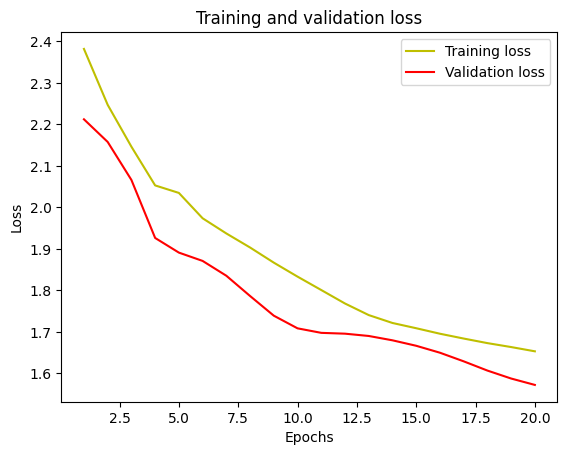

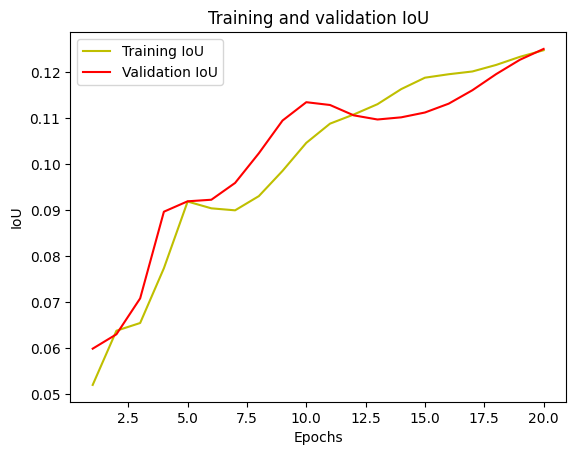

In [57]:
#plot the training and valida###########tion accuracy and loss at each epoch
history = history1
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['jacard_coef']

val_acc = history.history['val_jacard_coef']

plt.plot(epochs, acc, 'y', label='Training IoU')
plt.plot(epochs, val_acc, 'r', label='Validation IoU')
plt.title('Training and validation IoU')
plt.xlabel('Epochs')
plt.ylabel('IoU')
plt.legend()
plt.show()

In [58]:
#from simple_multi_unet_model import multi_unet_model, jacard_coef  
##################################
from keras.models import load_model
model = load_model("/home/jovyan/models/randomForrest_mask_unet_20epochs.hdf5",
                   custom_objects={'dice_loss_plus_2focal_loss': total_loss,
                                   'jacard_coef':jacard_coef})


#IOU
y_pred=model.predict(X_test)
y_pred_argmax=np.argmax(y_pred, axis=3)
y_test_argmax=np.argmax(y_test, axis=3)


#Using built in keras function for IoU
from keras.metrics import MeanIoU
n_classes = 10
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(y_test_argmax, y_pred_argmax)
print("Mean IoU =", IOU_keras.result().numpy())

1/1 [==============================] - 0s 452ms/step
Mean IoU = 0.112670965


1/1 [==============================] - 0s 67ms/step


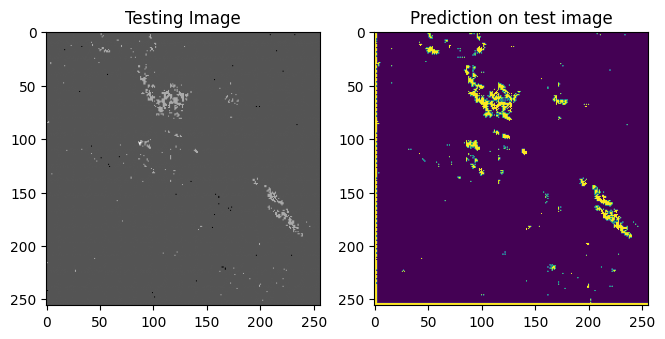

In [66]:
#Predict on a few images

import random
test_img_number = random.randint(0, len(X_test))
test_img = X_test[test_img_number]
ground_truth=y_test_argmax[test_img_number]
#test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img, 0)
prediction = (model.predict(test_img_input))
predicted_img=np.argmax(prediction, axis=3)[0,:,:]


plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img)
plt.subplot(232)
#plt.title('Testing Label')
plt.imshow(ground_truth)
#plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(predicted_img)
plt.show()


In [102]:
################ predict on new images ##############################
new_image_dataset = []  

root_directory = '/home/jovyan/output'

for path, subdirs, files in os.walk(root_directory):
    print(path)  
    dirname = path.split(os.path.sep)[-1]
    #if dirname == 'R10m':   #Find all 'images' directories
    if dirname == 'output':   #Find all 'images' directories
        images = os.listdir(path)  #List of all image names in this subdirectory
        for i, image_name in enumerate(images):  
            if image_name.endswith("rgb_nir_20240212.tif"):   #Only read jpg images...
               
                image = cv2.imread(path+"/"+image_name, 1)  #Read each image as BGR
                SIZE_X = (image.shape[1]//patch_size)*patch_size #Nearest size divisible by our patch size
                SIZE_Y = (image.shape[0]//patch_size)*patch_size #Nearest size divisible by our patch size
                image = Image.fromarray(image)
                image = image.crop((0 ,0, SIZE_X, SIZE_Y))  #Crop from top left corner
                #image = image.resize((SIZE_X, SIZE_Y))  #Try not to resize for semantic segmentation
                image = np.array(image)             
       
                #Extract patches from each image
                print("Now patchifying image:", path+"/"+image_name)
                patches_img = patchify(image, (patch_size, patch_size, 3), step=patch_size)  #Step=256 for 256 patches means no overlap
        
                for i in range(patches_img.shape[0]):
                    for j in range(patches_img.shape[1]):
                        
                        single_patch_img = patches_img[i,j,:,:]
                        
                        #Use minmaxscaler instead of just dividing by 255. 
                        single_patch_img = scaler.fit_transform(single_patch_img.reshape(-1, single_patch_img.shape[-1])).reshape(single_patch_img.shape)
                        
                        #single_patch_img = (single_patch_img.astype('float32')) / 255. 
                        single_patch_img = single_patch_img[0] #Drop the extra unecessary dimension that patchify adds.                               
                        new_image_dataset.append(single_patch_img)

/home/jovyan/output
Now patchifying image: /home/jovyan/output/sololo_rgb_nir_20240212.tif
/home/jovyan/output/.ipynb_checkpoints


In [103]:
print (SIZE_X, SIZE_Y)
len(new_image_dataset)

2304 2304


81

1/1 [==============================] - 0s 74ms/step


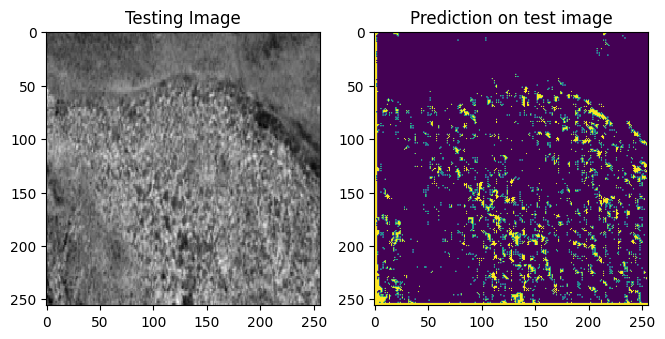

In [104]:
########### predict on new images #########################
#from sklearn.model_selection import train_test_split
#X_train, X_test, y_train, y_test = train_test_split(new_image_dataset, labels_cat, test_size = 1, random_state = 42)

X_test = new_image_dataset

import random

test_img_number = random.randint(0, len(X_test))
#test_img_number = random.randint(0, 32)
test_img = X_test[test_img_number]
#ground_truth=y_test_argmax[test_img_number]
test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img, 0)
prediction = (model.predict(test_img_input))
predicted_img=np.argmax(prediction, axis=3)[0,:,:]


plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img)
plt.subplot(232)
#plt.title('Testing Label')
plt.imshow(ground_truth)
#plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(predicted_img)
plt.show()

In [105]:
import random

predicted_images = []

for test_img_number in range(len(X_test)):
    test_img = X_test[test_img_number]
    #ground_truth = y_test_argmax[test_img_number]
    test_img_input = np.expand_dims(test_img, 0)
    prediction = model.predict(test_img_input)
    predicted_img = np.argmax(prediction, axis=3)[0, :, :]
    predicted_images.append(predicted_img)
    
#    plt.figure(figsize=(12, 8))
#    plt.subplot(231)
#    plt.title('Testing Image')
#    plt.imshow(test_img)
#   # plt.subplot(232)
#   # plt.title('Ground Truth')
#   # plt.imshow(ground_truth)
#    plt.subplot(232)
#    plt.title('Prediction')
#    plt.imshow(predicted_img)
#    plt.show()
len(predicted_images)

1/1 [==============================] - 0s 57ms/step


81

In [106]:
import numpy as np

def puzzle(image_set):
    # Determine the number of rows and columns in the grid based on the number of images
    num_images = len(image_set)
    grid_rows = int(np.ceil(np.sqrt(num_images)))  # Number of rows
    grid_cols = int(np.ceil(num_images / grid_rows))  # Number of columns
    
    # Initialize an empty array to hold the combined image
    #combined_image = np.zeros((256 * grid_rows, 256 * grid_cols, 3))  # Assuming RGB images
    combined_image = np.zeros((256 * grid_rows, 256 * grid_cols))
    
    # Iterate through all the images and combine them into the combined_image array
    for i in range(grid_rows):
        for j in range(grid_cols):
            image_index = i * grid_cols + j
            if image_index < num_images:
                predicted_img = predicted_images[image_index]
                combined_image[i*256:(i+1)*256, j*256:(j+1)*256] = predicted_img
    
    # Display the combined image
    plt.figure(figsize=(30, 24))
    plt.imshow(combined_image.astype(np.uint8))
    plt.axis('off')
    plt.show()

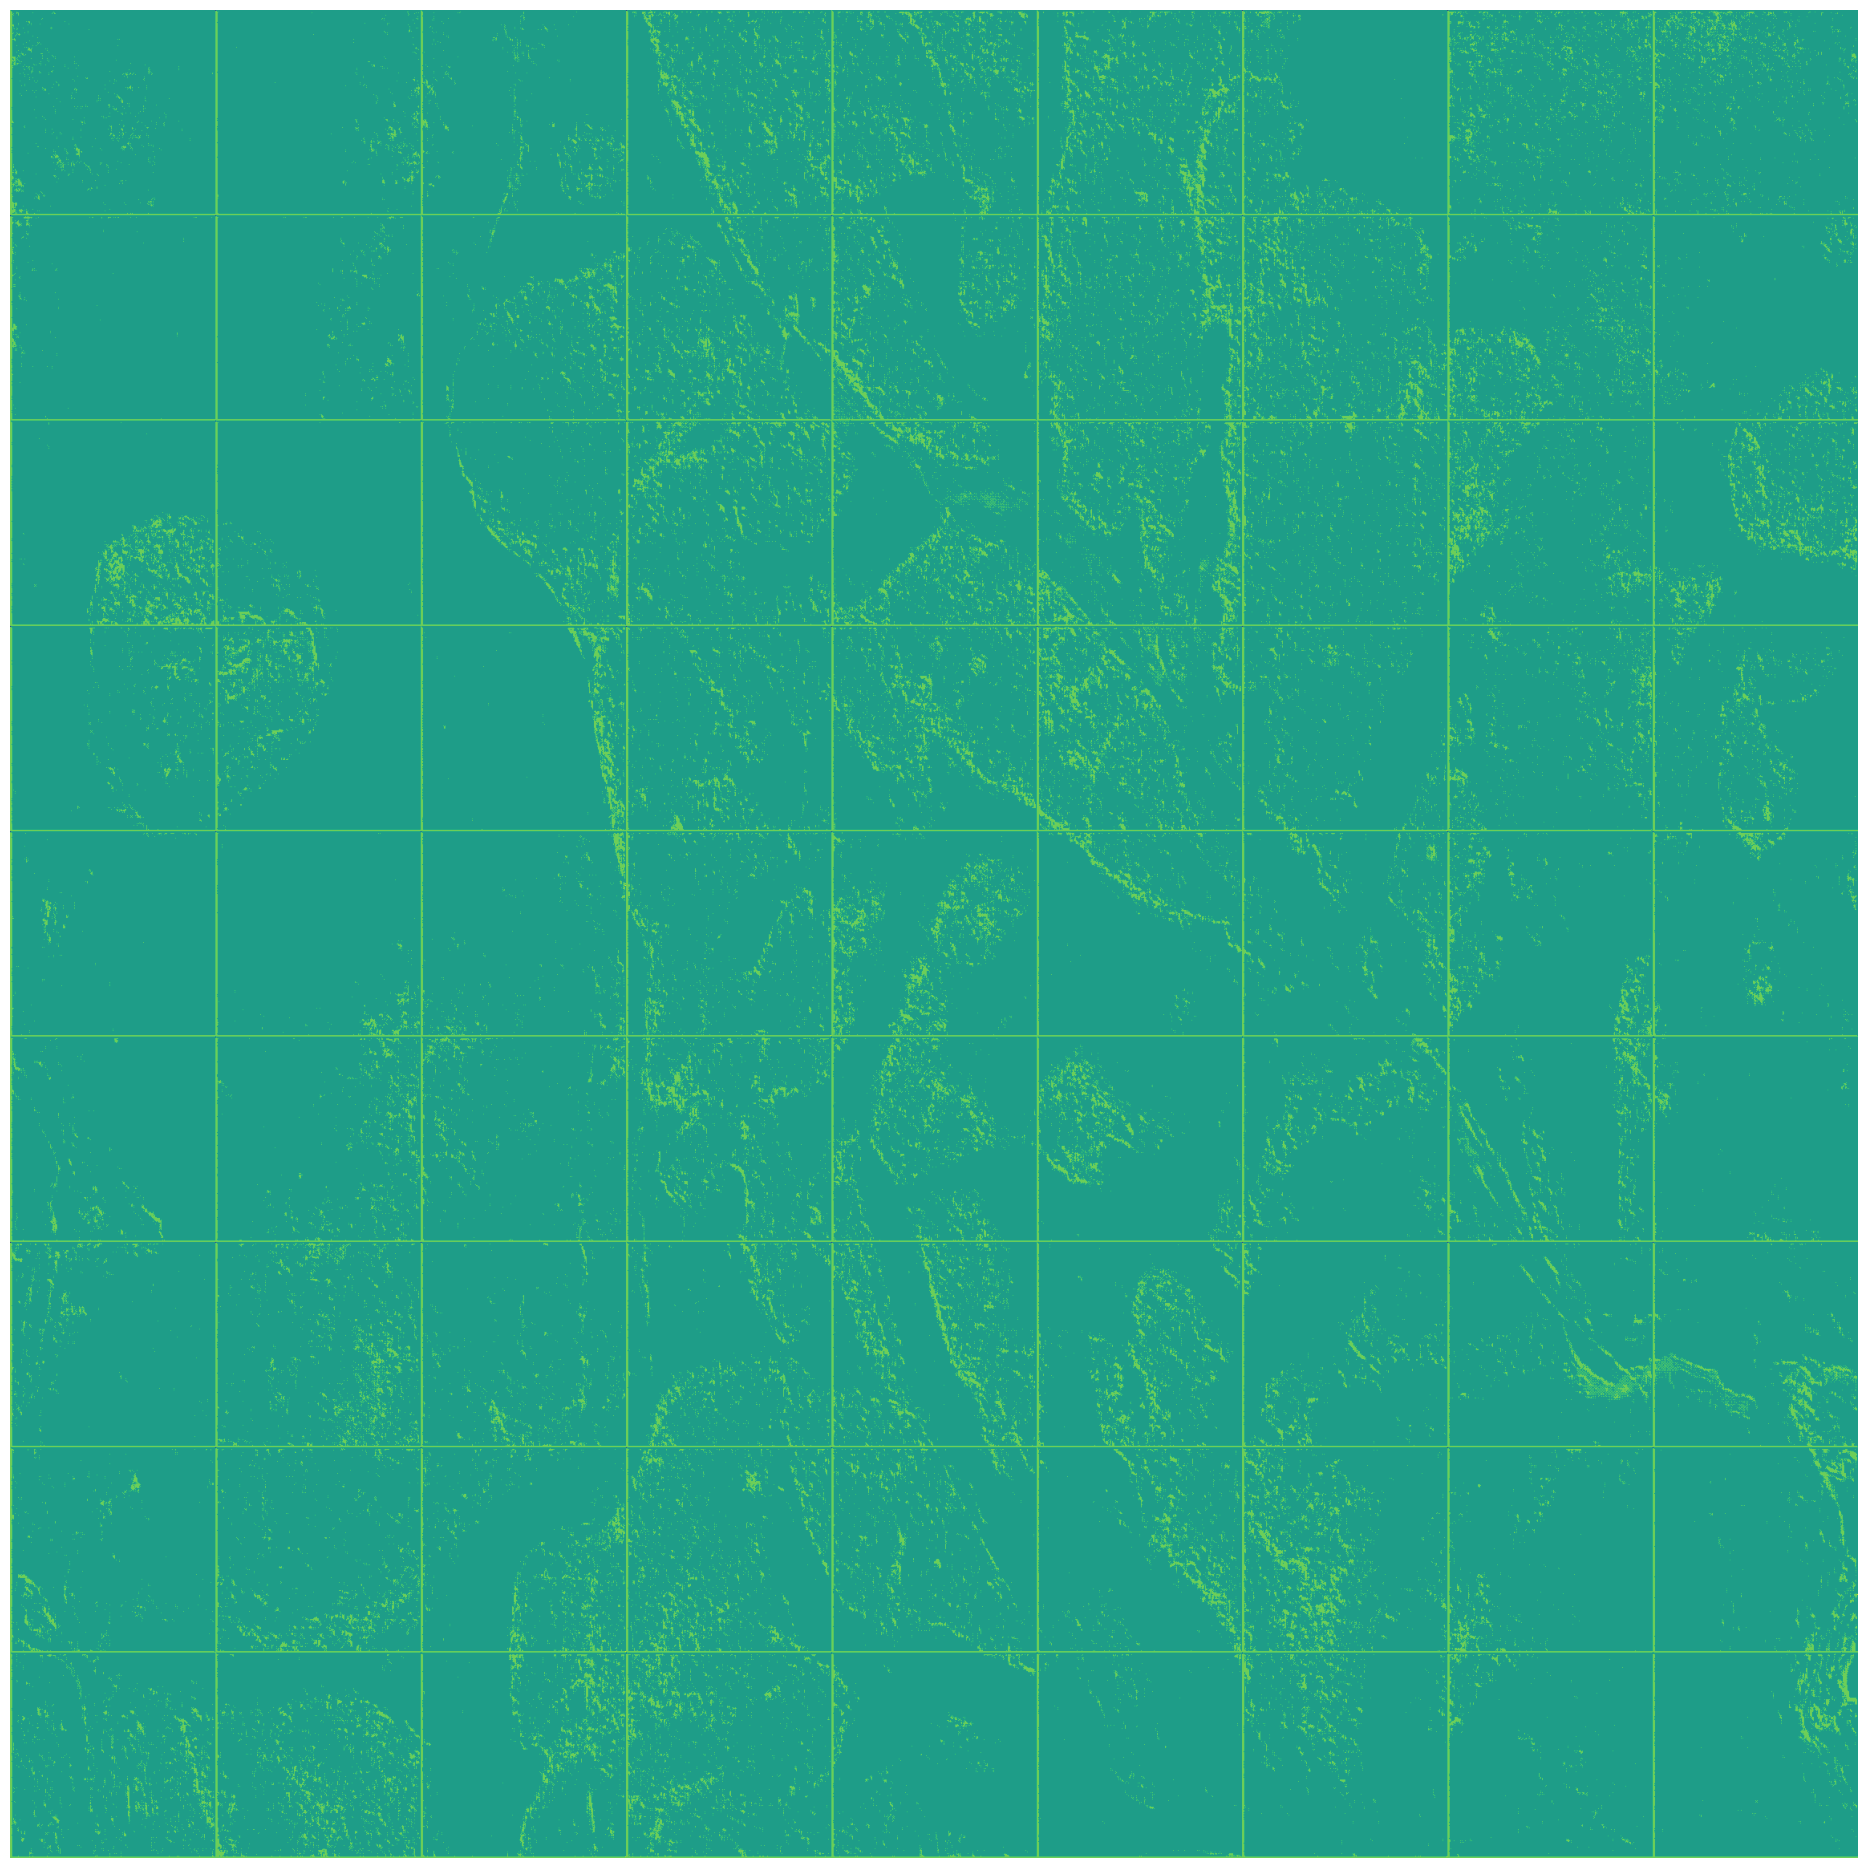

In [107]:
puzzle(new_image_dataset)

In [108]:
new_image_dataset = np.array(new_image_dataset)
new_image_dataset.shape

(81, 256, 256, 3)

In [77]:
type(combined_image)

numpy.ndarray

/home/jovyan/output
/home/jovyan/output/.ipynb_checkpoints


Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


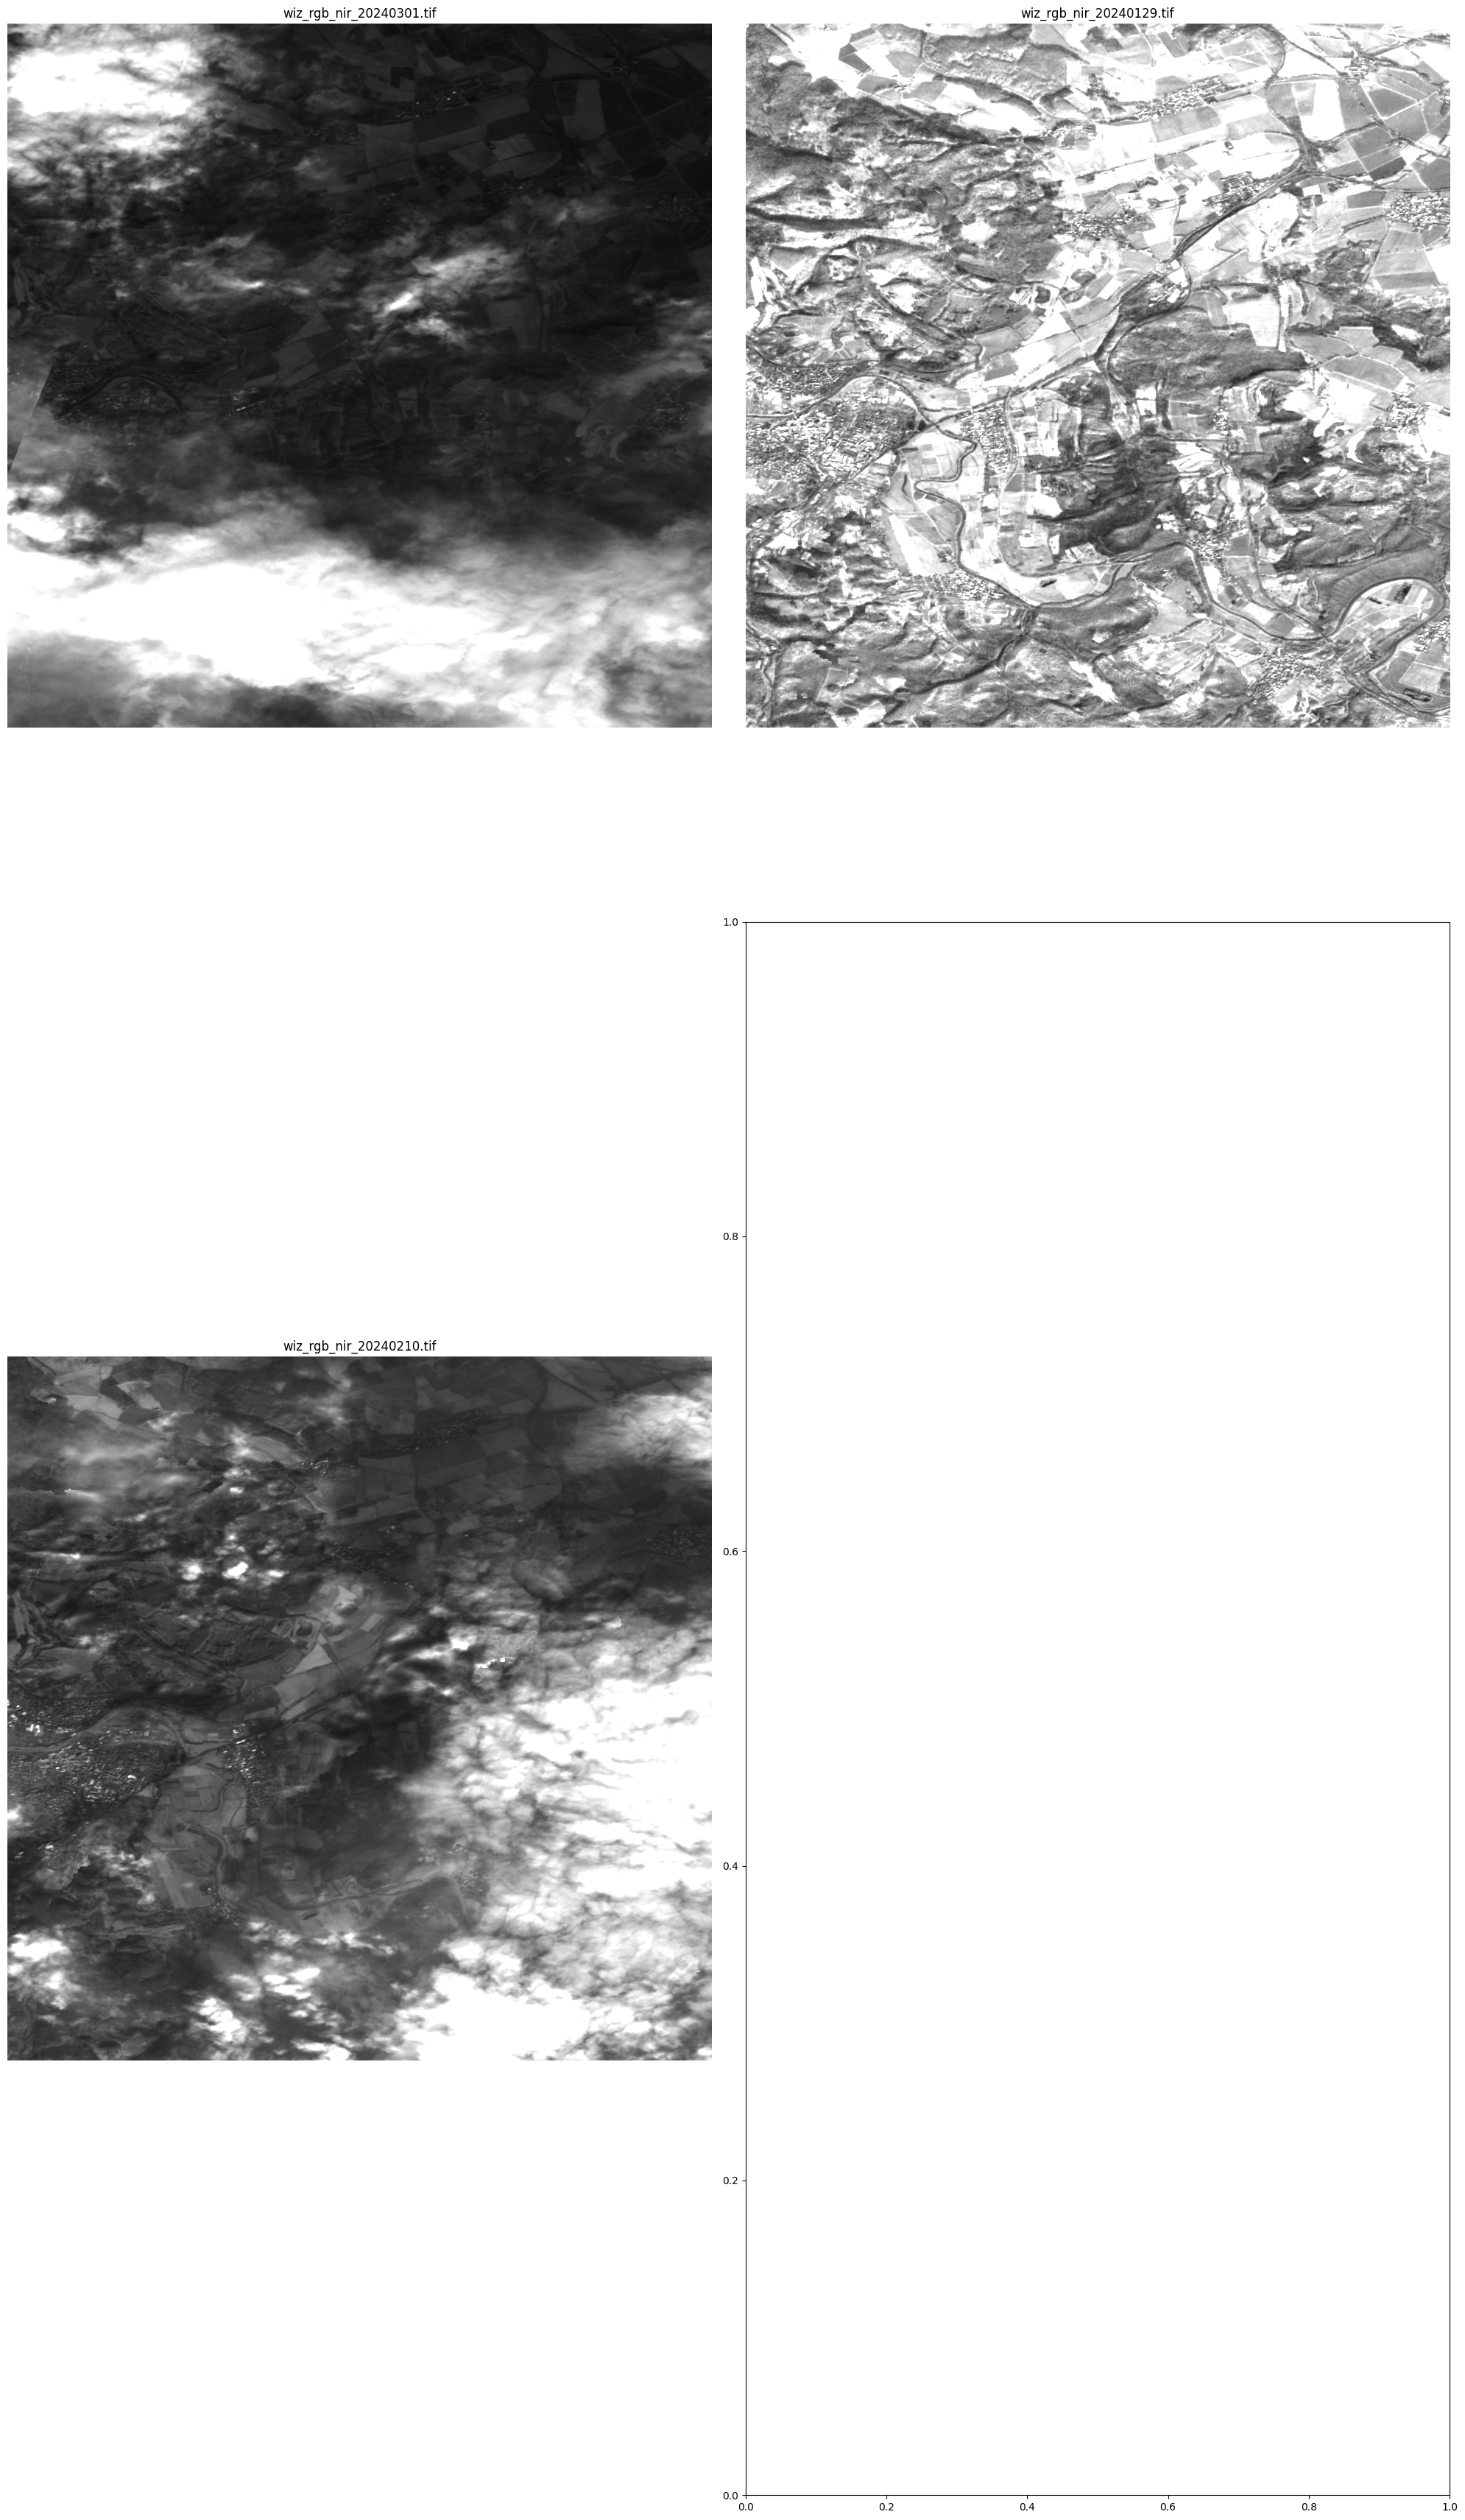

In [26]:
#### load images ####
import rasterio as rio
from rasterio.plot import show
import os
import numpy as np

root_directory = '/home/jovyan/output'
 
image_list = []

for path, subdirs, files in os.walk(root_directory):
    print(path)  
    dirname = path.split(os.path.sep)[-1]
    #if dirname == 'R10m':   #Find all 'images' directories
    if dirname == 'output':   #Find all 'images' directories
        images = os.listdir(path)  #List of all image names in this subdirectory
        for i, image_name in enumerate(images):  
            #if image_name.startswith("sololo_rgb_nir_202402"):   #Only read jpg images...
            if image_name.startswith("wiz"):   #Only read jpg images...
               #print(image_name)
               image_list.append(image_name)
               #image_name = rio.open(root_directory+'/'+image_name)
image_list

num_images = len(image_list)
num_rows = (num_images + 1) // 2  # Round up for odd number of images
fig, axs = plt.subplots(figsize=[20, 40], ncols=2, nrows=num_rows)

#for image in image_list:
for idx, image in enumerate(image_list):
    raster = rio.open(root_directory+'/'+image)
    arr = raster.read()
    vmin, vmax = np.nanpercentile(arr, (5,95))  # 5-95% contrast stretch

    row_idx = idx // 2  # Calculate the row index for the subplot
    col_idx = idx % 2   # Calculate the column index for the subplot
    ax = axs[row_idx, col_idx]  # Get the axis for the current image
    
    show(raster, cmap='gray', vmin=vmin, vmax=vmax, ax=ax)
    ax.set_title(image)
    ax.set_axis_off()

plt.tight_layout()
plt.show()
    
    #fig, ax = plt.subplots(figsize=[10,10], ncols=1, nrows=1)
    #show(raster, cmap='gray', vmin=vmin, vmax=vmax, ax=ax)
    ##show(raster, cmap='gray', ax=ax)
    #ax.set_title(image)
    #ax.set_axis_off()
    #fig.savefig("kargi.jpg", bbox_inches='tight')
   # plt.show()